# Bayesian inference of biomass composition on _C. autoethanogenum_
Use an embedded constraint-based metabolic model programming problem inside a bayesian model to infer a better biomass composition.

With this setup, we try to answer the question:

> Can a different but reasonable biomass composition recapitulate the observed byproduct formation of _C. autoethanogenum_?

since the byproduct formation (production of acetate, ethanol and 2,3-BDO) cannot be predicted using the genome-scale metabolic model. Here, "reasonable" is implied in the prior.

The generative model is a non-centered partial pooling (over conditions $c$) of the biomass components $m$:

$$
\begin{align*}
	\mu_m &\sim \mathcal{D}(\mathcal{C}(\textit{biomass coefficient}_m, \textit{length}(m))) \\
	\mu_{c,m} &\sim \mathcal{D}(\mathcal{C}(\mu_m, \textit{length}(m))) \\
\end{align*}
$$

then I take a weighted softmax on $\theta_{c}$ which becomes the objective of the LP for each condition $c$. The likelihood is the L2 norm of the expected exchange fluxes to the ones computed by the model. For $sigma$, I arbitrarily took half of the prior biomass stoichiometric coefficients.

I show a PGM below which may be more clear.

Figures for my thesis generated in this notebook:

1. [PGM sketch](#Bayesian-model).
1. [Posterior biomass coefficients](#Figure:-posterior-distribution-of-mass-coefficients).
1. [Posterior byproduct formation](#Figure:-posterior-byproduct-formation).
1. [Rate of acetate/ethanol](#Figure:-Rate-of-acetate/ethanol).

In [1]:
from pathlib import Path

import aesara.tensor as at
import arviz as az
import cobra
import numpy as np
import pandas as pd
import pymc as pm
from tqdm import tqdm

from base_conditions import apply_base_conditions

In [2]:
ROOT = Path.cwd().parent
MODEL_FILE = ROOT / "models" / "iCLAU786.xml"
DATA = ROOT / "data"

## Custom likelihood to embed the LP into the bayesian model

In [3]:
class LogLike(at.Op):

    """
    Specify what type of object will be passed and returned to the Op when it is
    called. In our case we will be passing it a vector of values (the parameters
    that define our model) and returning a single "scalar" value (the
    log-likelihood)
    """

    itypes = [at.dmatrix]  # expects a vector of parameter values when called
    otypes = [at.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, lp, sigma):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        lp:
            cobra Model
        sigma:
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.lp = lp.copy()
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.lp, self.data, self.sigma)

        outputs[0][0] = np.array(logl)


def apply_condition(lp: cobra.Model, df: pd.DataFrame, condition: str):
    """Modify cobra.Model in place, fixing bounds as specified in df[value, condition]."""
    this_lp = lp
    df_cond = df.loc[df.condition == condition, ["var", "value", "reaction"]]
    for _, (_, value, reaction) in df_cond.loc[df_cond["var"] == "input", :].iterrows():
        this_lp.reactions.get_by_id(reaction).bounds = value, value
    return this_lp


def my_model(theta, lp, df: pd.DataFrame):
    """Get a prediction for a given biomass function."""
    this_model = lp
    # this_model = lp.copy()
    reactants = this_model.reactions.bio2_c0.reactants
    assert len(theta) == len(
        reactants
    ), f"wrong index dim, theta={theta}, lp.reactants={reactants}"
    this_model.reactions.bio2_c0.add_metabolites(
        {
            # avoid removing mets because of coef ~= 0
            met: -max(coef, 1e-5)
            for met, coef in zip(reactants, theta)
        },
        False,
    )
    fluxes = this_model.optimize()
    return fluxes[df[df["var"] == "pred"].reaction]


def my_loglike(theta, lp, data, sigma):
    """Compute log-likelihood as norm-2 over LP solution."""
    acc = 0
    for i, cond in enumerate(pd.unique(data.condition)):
        df = data[data["condition"] == cond]
        apply_condition(lp, df, cond)
        model = my_model(theta[i, :], lp, df)
        acc += np.sum((df[df["var"] == "pred"].value - model) ** 2)
    return -(0.5 / sigma ** 2) * acc

## Setup data for inference

In [4]:
# prepare metabolic model
lp = cobra.io.read_sbml_model(str(MODEL_FILE))
# set a timeout just in case GLPK gets stuck (5s)
lp.solver.configuration.timeout = 5
# these are considerations and modifications of this particular metabolic model
apply_base_conditions(lp, DATA / "exchange_groups.json")
df: pd.DataFrame = pd.read_csv(DATA / "df_param.csv", index_col=0)

# Bayesian model for three conditions (partial pooling, non-centered)

# set up our data
sigma = 1.0
logl = LogLike(my_loglike, df, lp, sigma)

The df contains the observed values for uptake of gas (input for the model) and byproduct formation (output, the values to be predicte).

In [5]:
df

condition    var  value        reaction
0    syngas  input  12.91  cpd00011_ext_b
1    syngas  input -12.87  cpd11640_ext_b
2    syngas  input -31.56  cpd00204_ext_b
3    syngas  input  -0.08  cpd00084_ext_b
0    syngas   pred   4.25  cpd00029_ext_b
1    syngas   pred   3.74  cpd00363_ext_b
2    syngas   pred   0.09  cpd01947_ext_b
0        co  input  21.27  cpd00011_ext_b
1        co  input   0.47  cpd11640_ext_b
2        co  input -34.57  cpd00204_ext_b
3        co  input  -0.08  cpd00084_ext_b
0        co   pred   3.21  cpd00029_ext_b
1        co   pred   2.57  cpd00363_ext_b
2        co   pred   0.06  cpd01947_ext_b
0    h2high  input   4.39  cpd00011_ext_b
1    h2high  input -32.52  cpd11640_ext_b
2    h2high  input -25.33  cpd00204_ext_b
3    h2high  input  -0.08  cpd00084_ext_b
0    h2high   pred   1.92  cpd00029_ext_b
1    h2high   pred   7.78  cpd00363_ext_b
2    h2high   pred   0.00  cpd01947_ext_b

## Biomass objective function considerations

The biomass objective function needs to always be 1gDW. According to the model.

We can calculate the equivalent grams (l) as the sum of the reactants molecular weight multiplied by the stoichiometric coeffient. For each sample, it will be enforced that this value is always the same.

In [6]:
def get_complementary_mol_weight(metabolite: cobra.Metabolite):
    """Compute molecular weight of a biomass aggregated component."""
    reactions = [reac for reac in metabolite.reactions if reac.id != "bio2_c0"]
    assert len(reactions) == 1, "more than one reaction, dunno what to do"
    reaction = reactions[0]
    return abs(
        sum(
            met.formula_weight * -coeff
            for met, coeff in reaction.metabolites.items()
            if met != metabolite
        )
        / reaction.metabolites[metabolite]
    )

In [7]:
biomass_coefficients = {
    met.id[2:]: coeff
    for met, coeff in lp.reactions.bio2_c0.metabolites.items()
    if coeff < 0
}
mw = np.array(
    [get_complementary_mol_weight(met) for met in lp.reactions.bio2_c0.reactants]
)
# this mass cannot vary (should be 1000, but it is not...)
coeffs = np.array([-coeff for coeff in biomass_coefficients.values()])
total_mass = (mw * coeffs).sum()

/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/cobra/core/metabolite.py:103: UserWarning: 37.7 is not an integer (in formula C37.7H73.8NO8P)
  warn(
/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/cobra/core/metabolite.py:103: UserWarning: 73.8 is not an integer (in formula C37.7H73.8NO8P)
  warn(
/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/cobra/core/metabolite.py:103: UserWarning: 38.7 is not an integer (in formula C38.7H74.8O10P)
  warn(
/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/cobra/core/metabolite.py:103: UserWarning: 74.8 is not an integer (in formula C38.7H74.8O10P)
  warn(
/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/cobra/core/metabolite.py:103: UserWarning: 38.7 is not an integer (in formula C38.7H75.8NO8P)
  warn(
/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/cobra/core/metabolite.py:103: UserWarning: 75.8 is not an integer (in formula C38.7H75.8NO8P)
  warn(


## Bayesian model

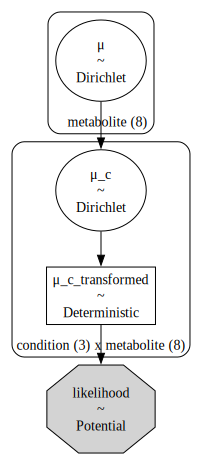

In [8]:
with pm.Model(
    coords={
        "condition": df.condition.unique(),
        "metabolite": biomass_coefficients.keys(),
    }
) as model:
    # parent dist; close it to the number of components to make the concentration
    # parameters around one (not that certain about them)
    mu = pm.Dirichlet("μ", a=coeffs * len(coeffs) / sum(coeffs), dims="metabolite")
    # partial pooling
    mu_c = pm.Dirichlet(
        "μ_c", a=mu * len(coeffs) / pm.math.sum(mu), dims=["condition", "metabolite"]
    )
    # this achieves mmol/gDW consistency
    mu_soft = pm.Deterministic(
        "μ_c_transformed",
        mu_c * total_mass / mw,
        dims=["condition", "metabolite"],
    )
    passed_theta = at.as_tensor_variable(mu_soft)
    # black box: linear programming problem
    pm.Potential("likelihood", logl(passed_theta))

    # I am not super sure about race conditions over the cobra.Model...
    idata_mh = pm.model_to_graphviz()

pm.model_to_graphviz(model)

(notice that the likelihood is computed for each condition but, being a black box, pymc is not aware)

It is advisable to run this on a server, since it takes around 2 hours.
```python
with model:
    idata = pm.sample(2000, tune=1000)
idata.to_netcdf("biomass_partial_diri_closing.nc")
```

```
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8390 seconds.
```

## Plotting
I sampled in the workstation and brought the result here.

In [9]:
idata = az.from_netcdf(ROOT / "biomass_partial_diri_closing.nc")
model = cobra.io.read_sbml_model(str(MODEL_FILE))
model.solver.configuration.timeout = 5
apply_base_conditions(model, DATA / "exchange_groups.json")

In [10]:
model.reactions.bio2_c0.reaction

'0.0432 S_carbo_CA_c + 0.026 S_dna_CA_c + 0.076 S_lipid_CA_c + 0.1008 S_peptido_CA_c + 0.5284 S_protein_CA_c + 0.0655 S_rna_CA_c + 0.0495 S_solutepool_c + 0.1106 S_teichoic_CA_c <=> S_cpd11416_c'

In [11]:
model.metabolites.S_teichoic_CA_c

<Metabolite S_teichoic_CA_c at 0x79cbd0a52100>

Some evaluations of the likelihood may produce NaN since not all objective functions might produce a feasible LP problem. Let's look at the trace.

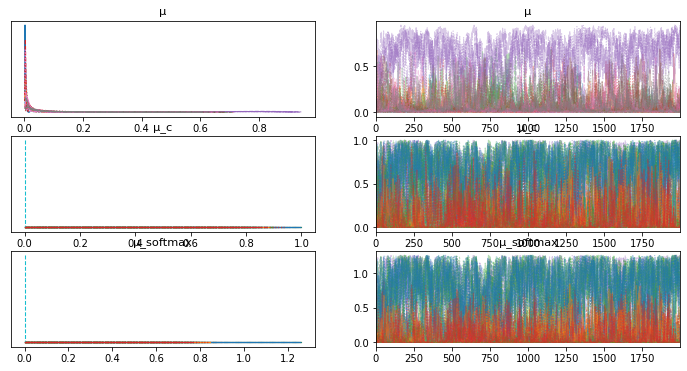

In [13]:
_ = az.plot_trace(idata)

/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (56) in plot_rank, generating only 40 plots
  warnings.warn(


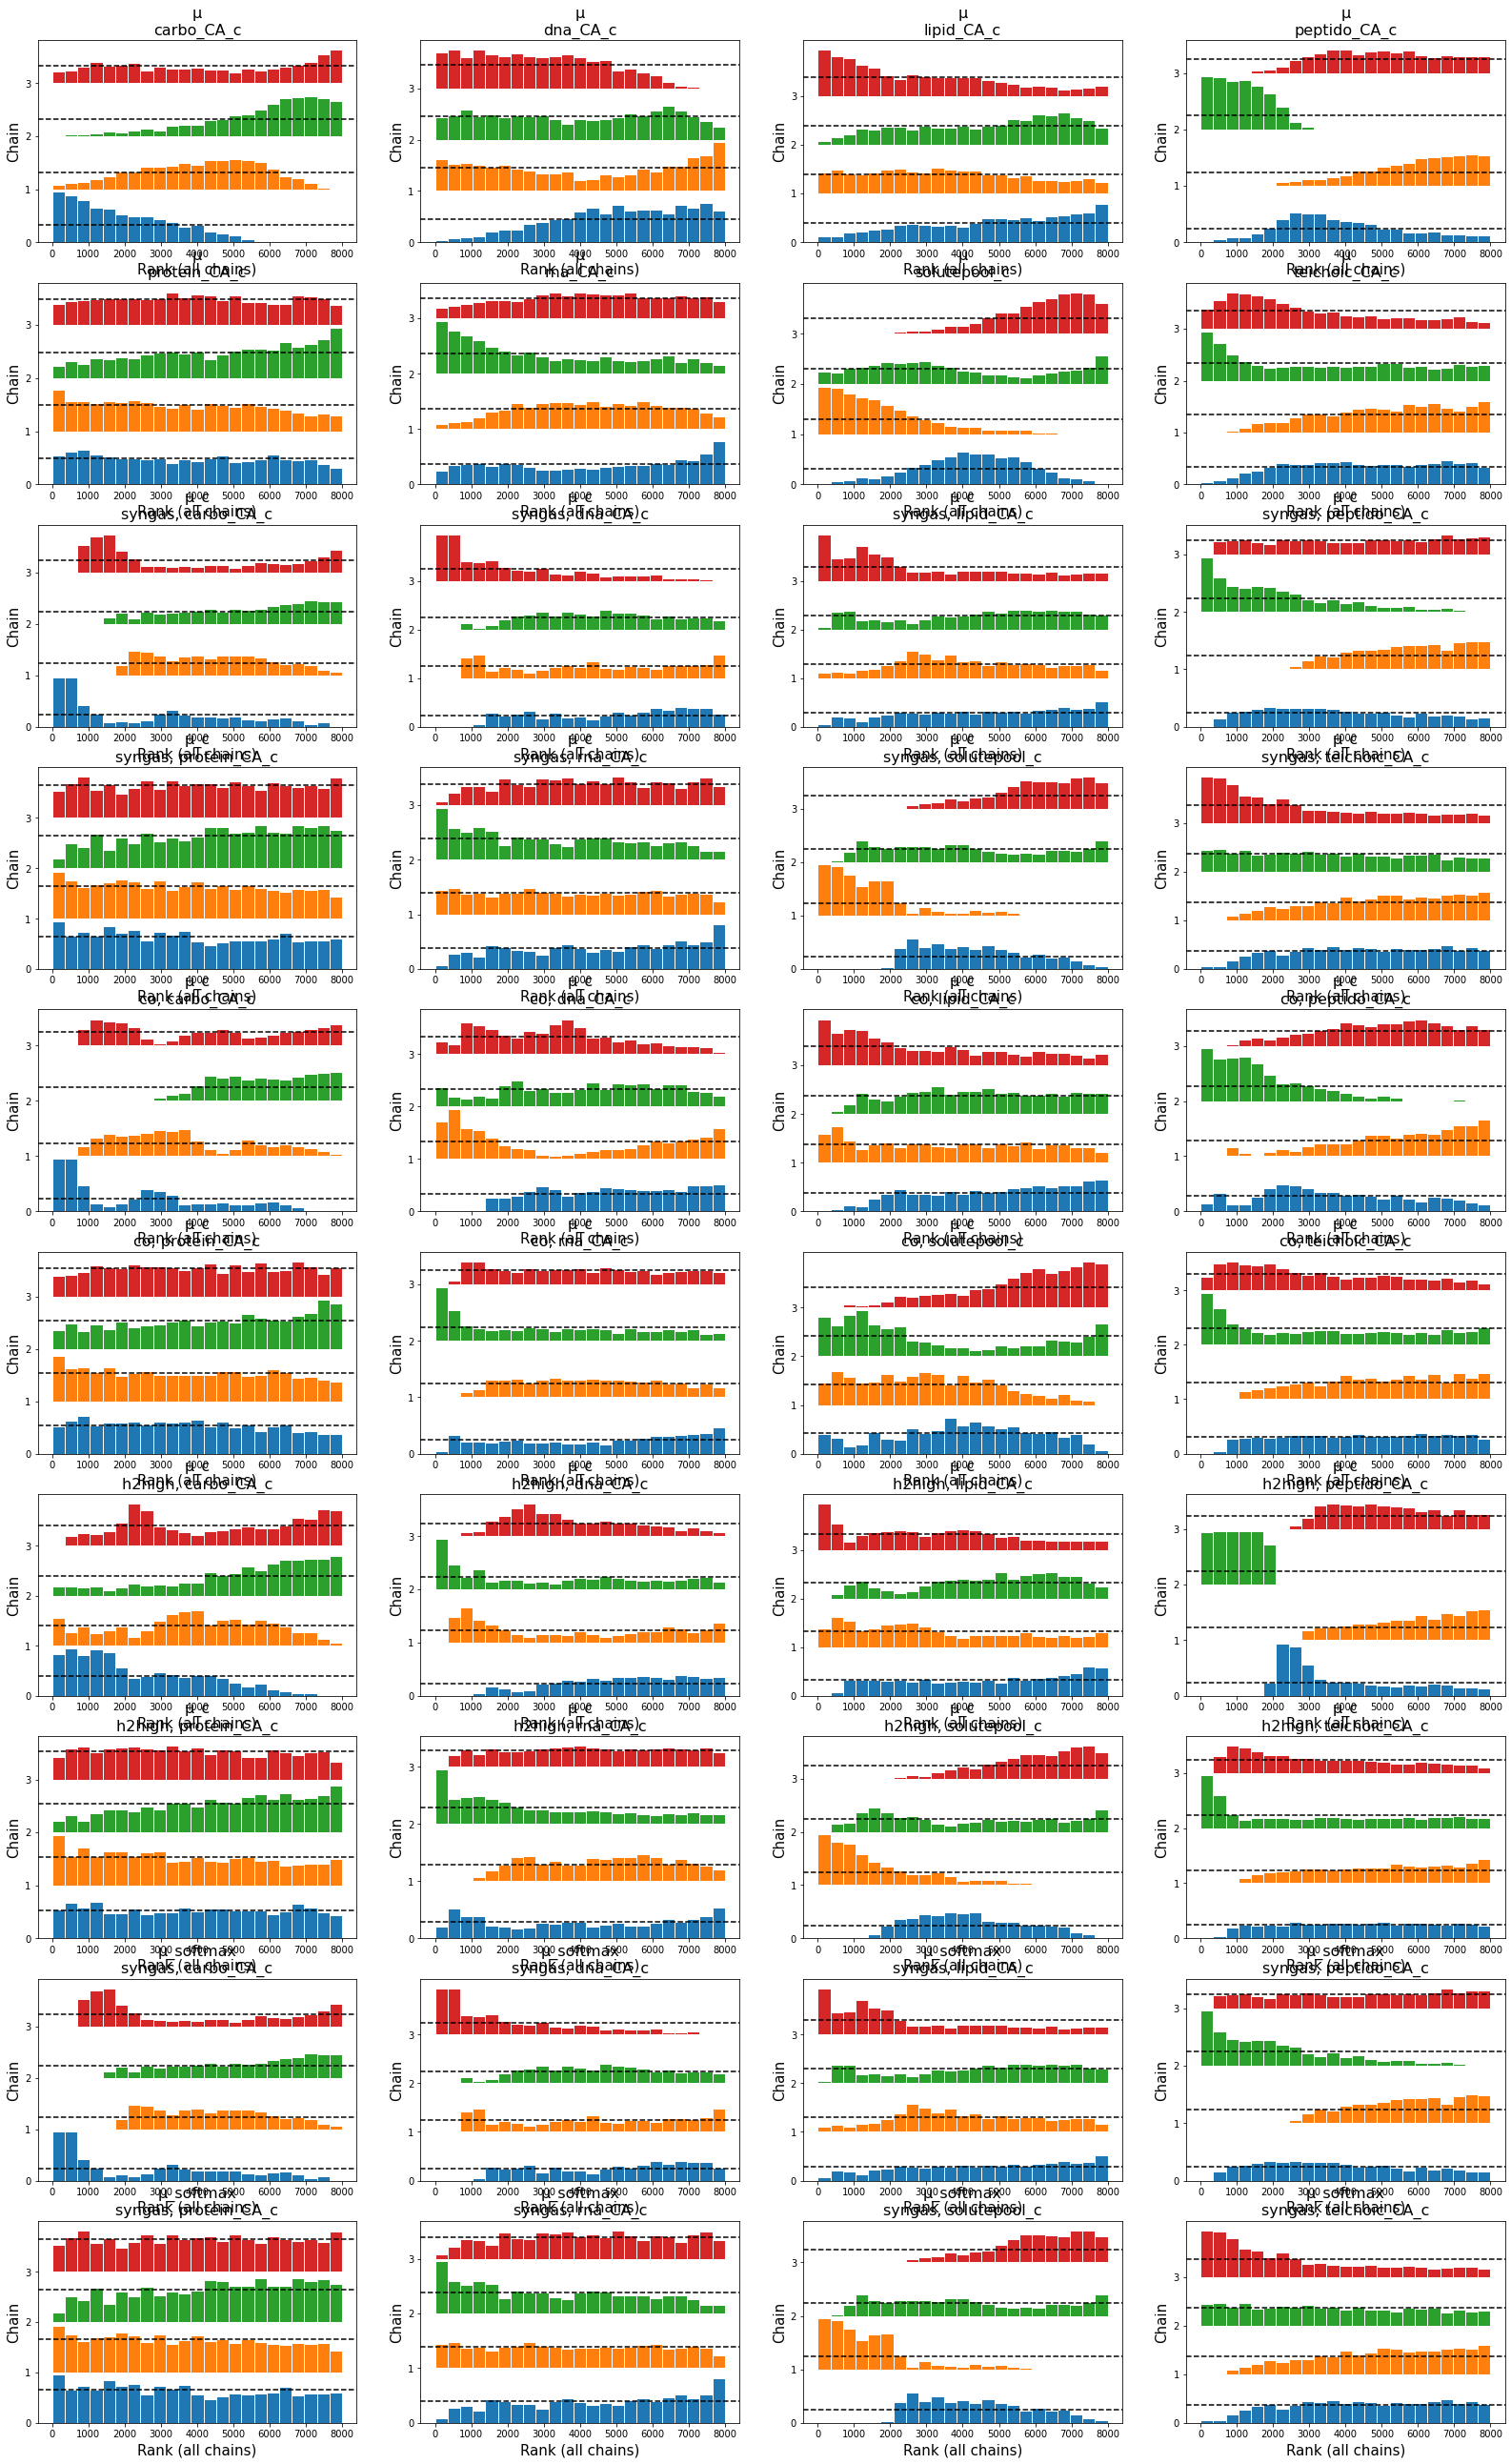

In [11]:
_ = az.plot_rank(idata)

I changed the name of "μ\_c\_transformed" from "μ\_softmax" because it is more adequate, but the resulting script
still uses "μ\_softmax".

μ_softmax is defined in the simplex closed by the total mass value. Let's check if it was properly sampled. 

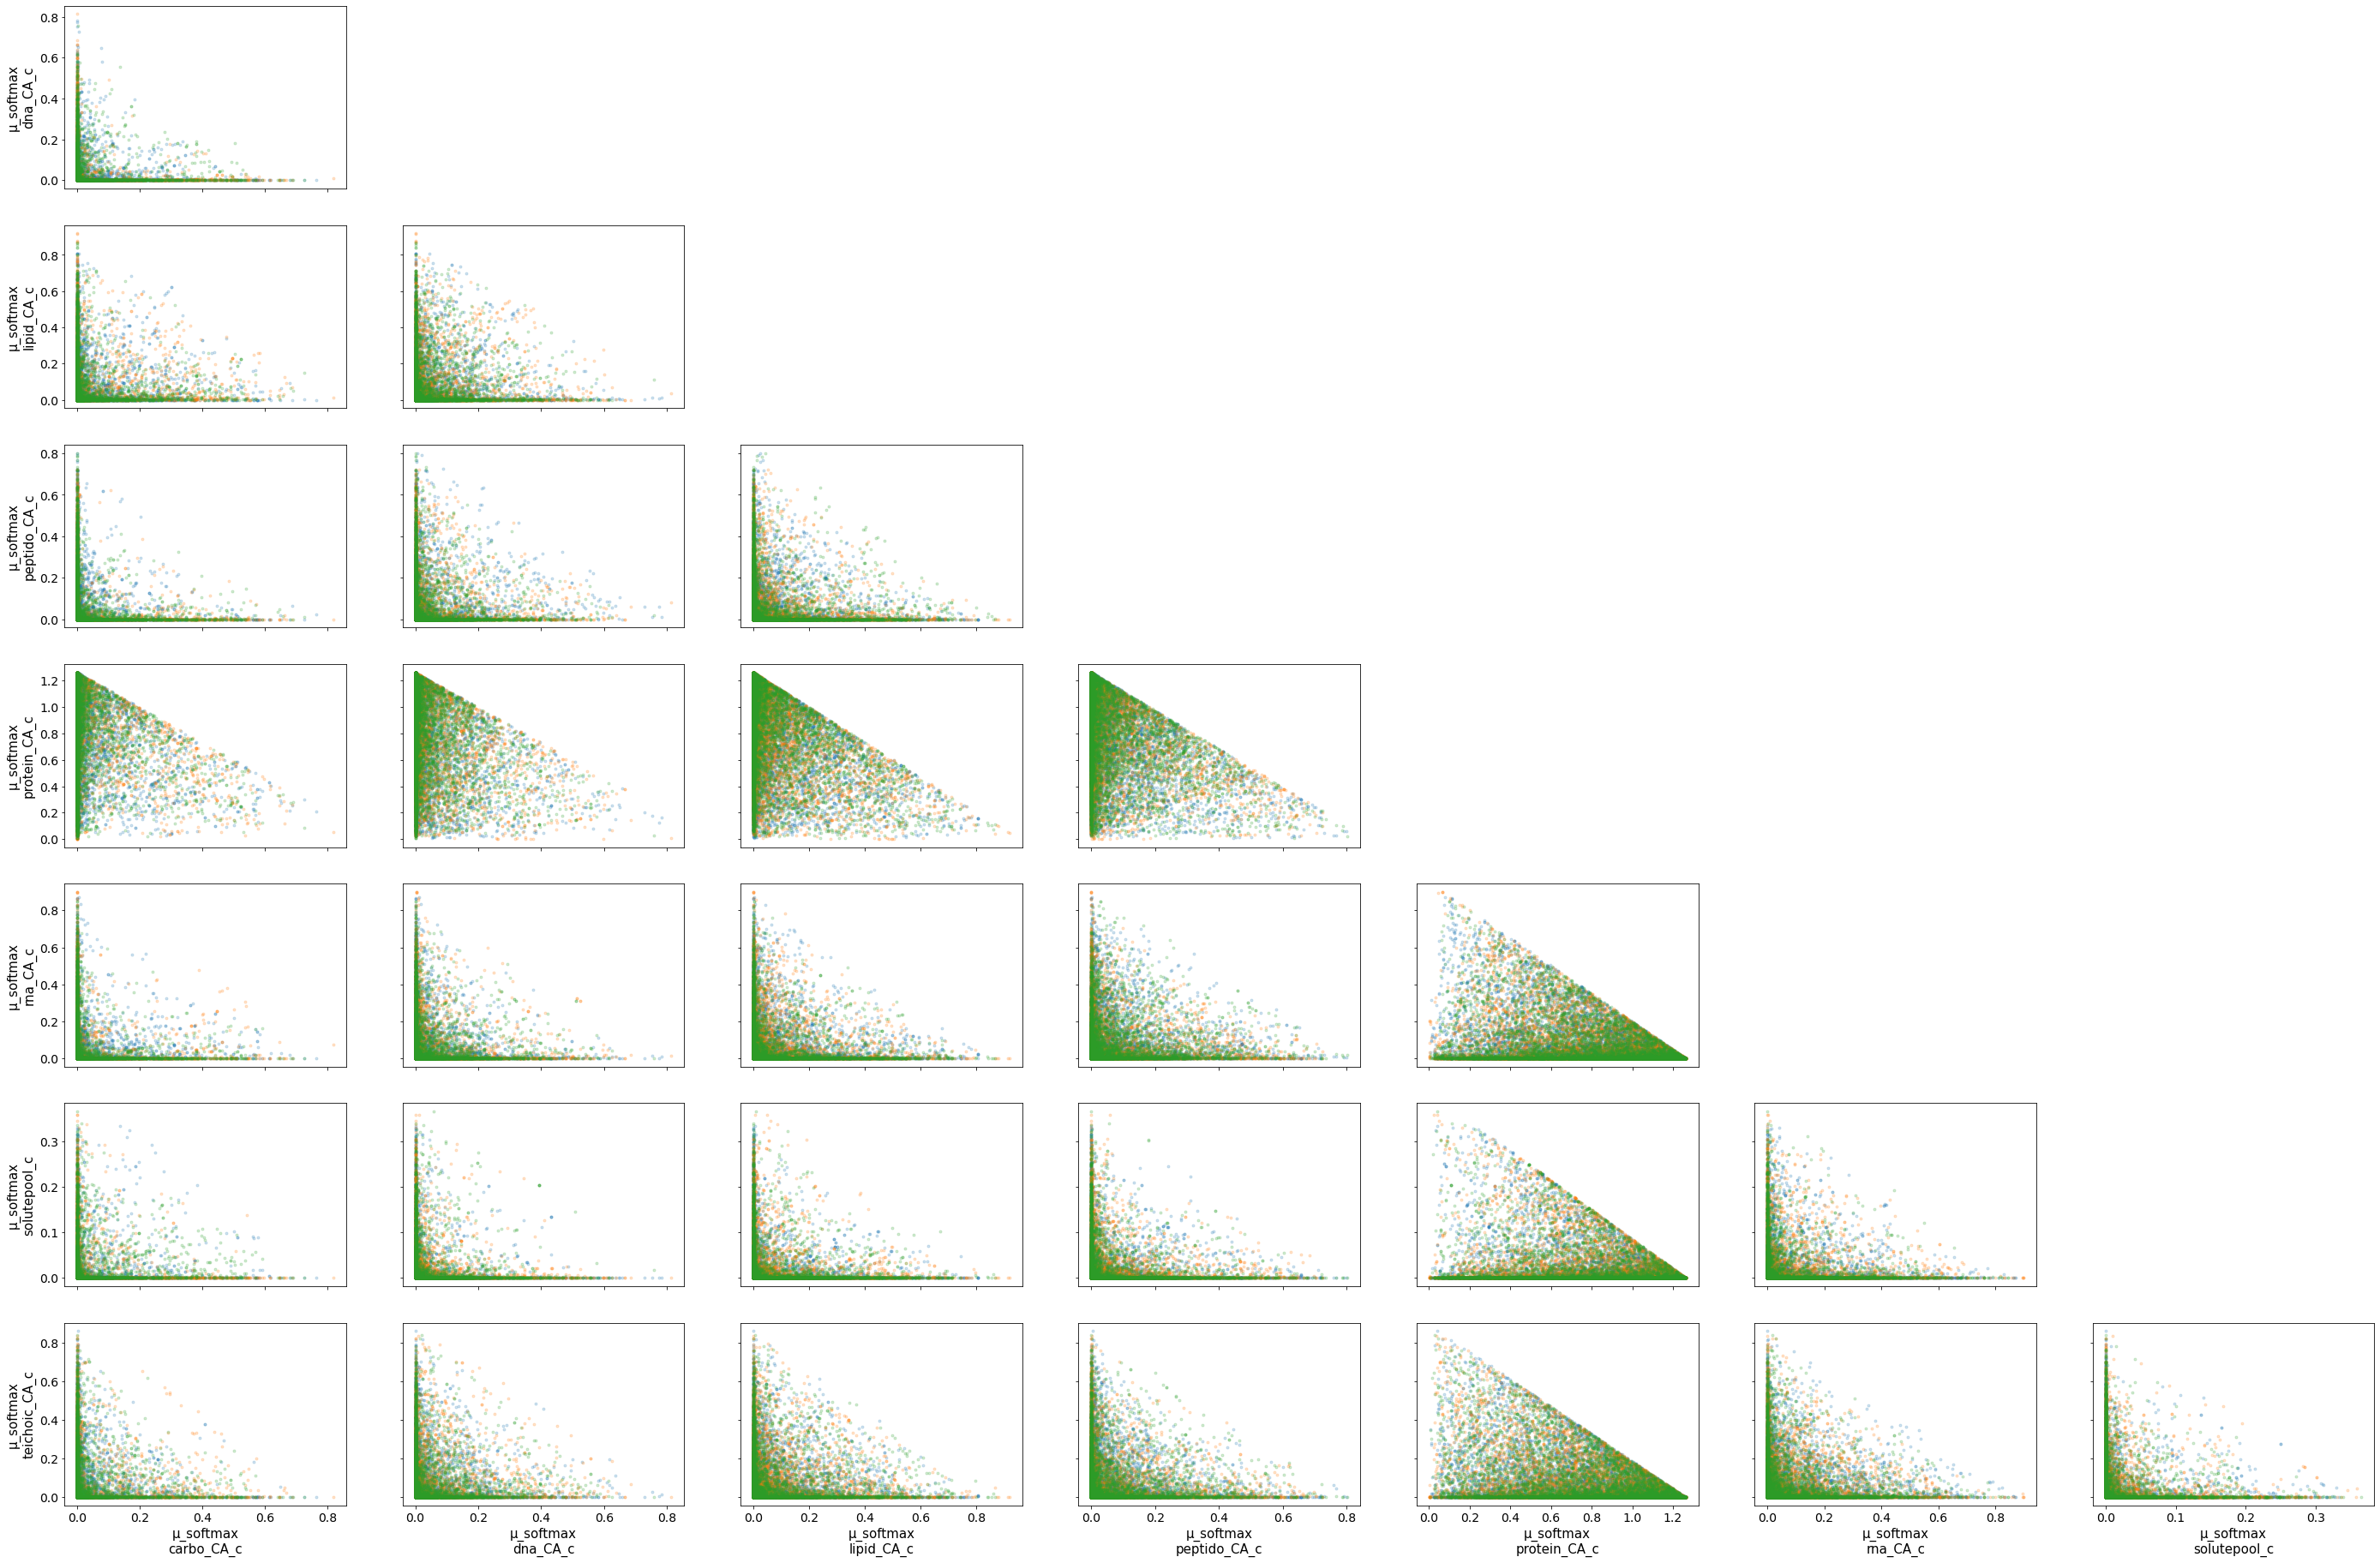

In [12]:
ax = az.plot_pair(
    idata,
    var_names="μ_softmax",
    coords={"condition": "syngas"},
    show=False,
    scatter_kwargs={"alpha": 0.2},
)
ax = az.plot_pair(
    idata,
    var_names="μ_softmax",
    coords={"condition": "co"},
    ax=ax,
    show=False,
    scatter_kwargs={"alpha": 0.2},
)
_ = az.plot_pair(
    idata,
    var_names="μ_softmax",
    coords={"condition": "h2high"},
    ax=ax,
    scatter_kwargs={"alpha": 0.2},
)

In [17]:
from itertools import product

In [34]:
idata.posterior

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 2000, metabolite: 8, condition: 3)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * metabolite  (metabolite) object 'carbo_CA_c' 'dna_CA_c' ... 'teichoic_CA_c'
  * condition   (condition) object 'syngas' 'co' 'h2high'
Data variables:
    μ           (chain, draw, metabolite) float64 0.001454 0.276 ... 0.002736
    μ_c         (chain, draw, condition, metabolite) float64 1.264e-05 ... 7....
    μ_softmax   (chain, draw, condition, metabolite) float64 1.206e-05 ... 6....
Attributes:
    created_at:                 2022-09-16T16:19:40.402571
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.1.4
    sampling_time:              8389.653239965439
    tuning_steps:               1000

In [28]:
mu_trans = idata.posterior["μ_softmax"]

In [42]:
df_mu_c_trans = pd.DataFrame({
    f"{met}ø{cond}": mu_trans.sel(metabolite=met, condition=cond).to_numpy().flatten()
    for met, cond in product(mu_trans.metabolite.to_numpy(), mu_trans.condition.to_numpy())
})
df_mu_c_trans.head()

carbo_CA_cøsyngas  carbo_CA_cøco  carbo_CA_cøh2high  dna_CA_cøsyngas  \
0           0.000012   4.146068e-50       3.133513e-11         0.131372   
1           0.000038   2.342688e-50       1.177435e-11         0.417559   
2           0.000038   1.881629e-50       1.325556e-11         0.417559   
3           0.000042   2.219764e-51       8.174129e-12         0.453237   
4           0.000043   2.642176e-51       2.433458e-12         0.151282   

   dna_CA_cøco  dna_CA_cøh2high  lipid_CA_cøsyngas  lipid_CA_cøco  \
0     0.348588         0.202753           0.000983       0.000193   
1     0.323249         0.104789           0.016103       0.000109   
2     0.259631         0.117972           0.016103       0.000088   
3     0.462860         0.411684           0.064688       0.000072   
4     0.369504         0.398983           0.060821       0.000086   

   lipid_CA_cøh2high  peptido_CA_cøsyngas  ...  protein_CA_cøh2high  \
0           0.004937             0.023743  ...             0.458900   
1           0.000841             0.069577  ...             0.822338   
2           0.002739             0.069577  ...             0.925788   
3           0.001422             0.046845  ...             0.534286   
4           0.003010             0.012759  ...             0.517802   

   rna_CA_cøsyngas  rna_CA_cøco  rna_CA_cøh2high  solutepool_cøsyngas  \
0         0.000144     0.044709         0.106476         7.158921e-12   
1         0.000863     0.014032         0.055031         5.269660e-11   
2         0.000863     0.005147         0.061953         5.269660e-11   
3         0.003045     0.028158         0.058030         5.719927e-11   
4         0.005749     0.102459         0.085255         2.467197e-09   

   solutepool_cøco  solutepool_cøh2high  teichoic_CA_cøsyngas  \
0     8.387821e-10         4.032696e-10              0.647927   
1     4.512489e-11         2.084234e-10              0.099486   
2     3.624396e-11         2.346430e-10              0.099486   
3     2.971857e-11         2.197844e-10              0.014476   
4     4.449154e-11         2.130035e-10              0.401221   

   teichoic_CA_cøco  teichoic_CA_cøh2high  
0          0.114532              0.264676  
1          0.161448              0.155375  
2          0.225495              0.060434  
3          0.088591              0.067600  
4          0.040892              0.064419  

[5 rows x 24 columns]

In [43]:
df_mu_c_trans = pd.melt(df_mu_c_trans, ignore_index=False, value_name="coefficient")

In [45]:
df_mu_c_trans[["metabolite", "condition"]] = df_mu_c_trans.variable.str.split("ø", expand=True)

In [47]:
from plotnine import *

In [77]:
biomass_coefficients

{'carbo_CA_c': -0.0432,
 'dna_CA_c': -0.026,
 'lipid_CA_c': -0.076,
 'peptido_CA_c': -0.1008,
 'protein_CA_c': -0.5284,
 'rna_CA_c': -0.0655,
 'solutepool_c': -0.0495,
 'teichoic_CA_c': -0.1106}

In [90]:
prior_coeff = pd.DataFrame({k: [-v] for k, v in biomass_coefficients.items()}).melt(var_name="metabolite", value_name="coefficient")

In [94]:
mu = idata.posterior["μ"]

In [105]:
df_mu  = pd.DataFrame({
    f"{met}": mu.sel(metabolite=met).to_numpy().flatten()
    for met in mu.metabolite.to_numpy()
})
df_mu.head()

carbo_CA_c  dna_CA_c  lipid_CA_c  peptido_CA_c  protein_CA_c  rna_CA_c  \
0    0.001454  0.275984    0.039276      0.008617      0.428707  0.041509   
1    0.003359  0.281038    0.023145      0.023783      0.262963  0.129079   
2    0.002930  0.281627    0.027964      0.063148      0.399268  0.060474   
3    0.001954  0.271520    0.054026      0.092273      0.416068  0.047862   
4    0.003623  0.262160    0.031835      0.030568      0.530885  0.026198   

   solutepool_c  teichoic_CA_c  
0      0.005047       0.199406  
1      0.013709       0.262924  
2      0.011168       0.153422  
3      0.005412       0.110885  
4      0.015499       0.099232

In [106]:
df_mu = pd.melt(df_mu, ignore_index=False, value_name="coefficient", var_name="metabolite")

In [119]:
prior_coeff["proc"] = "prior"
df_mu["proc"] = "posterior"

### Figure: posterior distribution of mass coefficients

First, the parent distribution, followed by the condition dependant one.

/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 2.4 x 5.4 in image.
/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: mu.pdf


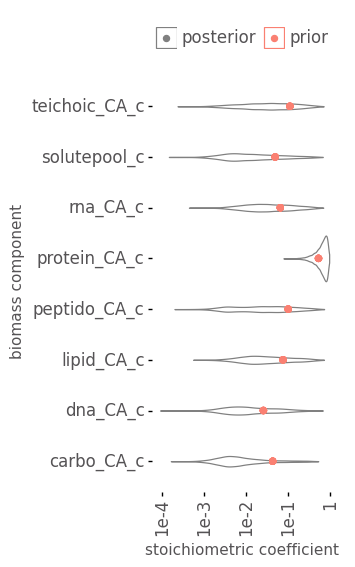

<ggplot: (8369732790562)>

In [153]:
mu_plot = (
    ggplot(df_mu, aes(x="metabolite", y="coefficient", color="proc"))
    #+ geom_jitter(alpha=0.01, height=0, width=0.1)
    + geom_violin(alpha=0)
    + geom_point(data=prior_coeff, size=2)
    + theme_tufte()
    + scale_y_log10()
    + xlab("biomass component")
    + ylab("stoichiometric coefficient")
    + theme(
        figure_size=(2.4, 5.4), legend_position="top", axis_text_x=element_text(angle=90),
        legend_title=element_blank(), text=element_text(size=12, color="#555355"),
        axis_title=element_text(size=11)
    )
    + scale_color_manual(["gray", "salmon"])
    + coord_flip()
)
mu_plot.save("mu.pdf", dpi=300)
mu_plot

In [135]:
prior_coeff = pd.concat([prior_coeff.assign(condition=cond.item()) for cond in idata.posterior.condition])

In [140]:
df_mu_c_trans["proc"] = "posterior"

/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7.4 x 5.4 in image.
/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: mu_c_trans.pdf
/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The fr

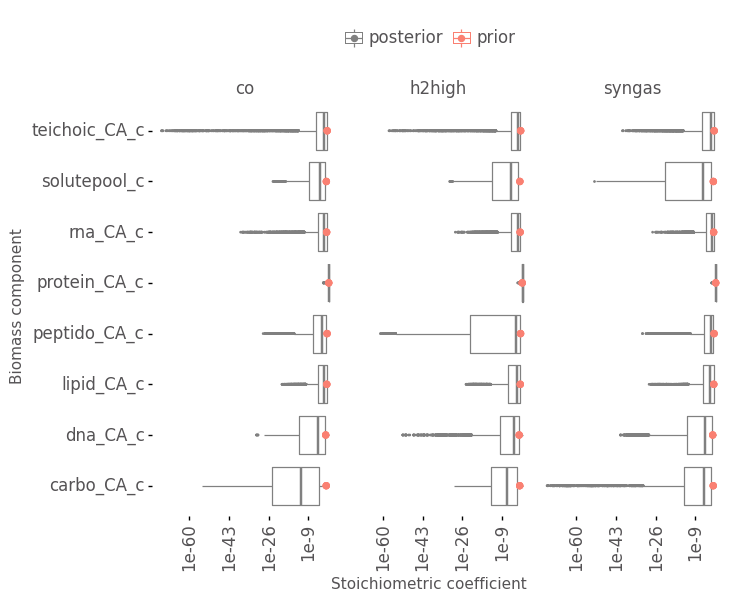

<ggplot: (8369732617563)>

In [155]:
mu_c_trans_plot = (
    ggplot(df_mu_c_trans, aes(x="metabolite", y="coefficient", color="proc"))
    #+ geom_jitter(alpha=0.01, height=0, width=0.1, raster=True)
    + geom_boxplot(alpha=0.2, outlier_size=0.1, raster=True)
    + geom_point(data=prior_coeff, size=2)
    + facet_wrap("~condition")
    + theme_tufte()
    + xlab("Biomass component")
    + ylab("Stoichiometric coefficient")
    + scale_y_log10()
    + theme(
        figure_size=(7.4, 5.4), legend_position="top", axis_text_x=element_text(angle=90),
        legend_title=element_blank(), text=element_text(size=12, color="#555355"),
        axis_title=element_text(size=11)
    )
    + scale_color_manual(["gray", "salmon"])
    + coord_flip()
)
mu_c_trans_plot.save("mu_c_trans.pdf", dpi=300)
mu_c_trans_plot

In [62]:
mu_c = idata.posterior["μ_c"]

In [64]:
df_mu_c  = pd.DataFrame({
    f"{met}ø{cond}": mu_c.sel(metabolite=met, condition=cond).to_numpy().flatten()
    for met, cond in product(mu_c.metabolite.to_numpy(), mu_c.condition.to_numpy())
})
df_mu_c.head()

carbo_CA_cøsyngas  carbo_CA_cøco  carbo_CA_cøh2high  dna_CA_cøsyngas  \
0           0.000013   4.347434e-50       3.285701e-11         0.137899   
1           0.000040   2.456468e-50       1.234620e-11         0.438303   
2           0.000040   1.973016e-50       1.389935e-11         0.438303   
3           0.000044   2.327573e-51       8.571130e-12         0.475754   
4           0.000045   2.770501e-51       2.551646e-12         0.158798   

   dna_CA_cøco  dna_CA_cøh2high  lipid_CA_cøsyngas  lipid_CA_cøco  \
0     0.365906         0.212826           0.001030       0.000202   
1     0.339309         0.109995           0.016871       0.000114   
2     0.272530         0.123833           0.016871       0.000092   
3     0.485855         0.432137           0.067773       0.000075   
4     0.387861         0.418804           0.063722       0.000090   

   lipid_CA_cøh2high  peptido_CA_cøsyngas  ...  protein_CA_cøh2high  \
0           0.005172             0.027179  ...             0.363784   
1           0.000881             0.079647  ...             0.651892   
2           0.002870             0.079647  ...             0.733900   
3           0.001490             0.053625  ...             0.423544   
4           0.003153             0.014606  ...             0.410477   

   rna_CA_cøsyngas  rna_CA_cøco  rna_CA_cøh2high  solutepool_cøsyngas  \
0         0.000151     0.046788         0.111429         1.759057e-11   
1         0.000904     0.014685         0.057590         1.294837e-10   
2         0.000904     0.005386         0.064835         1.294837e-10   
3         0.003187     0.029467         0.060730         1.405474e-10   
4         0.006017     0.107225         0.089221         6.062282e-09   

   solutepool_cøco  solutepool_cøh2high  teichoic_CA_cøsyngas  \
0     2.061017e-09         9.908953e-10              0.722578   
1     1.108788e-10         5.121283e-10              0.110948   
2     8.905698e-11         5.765540e-10              0.110948   
3     7.302309e-11         5.400440e-10              0.016144   
4     1.093226e-10         5.233823e-10              0.447448   

   teichoic_CA_cøco  teichoic_CA_cøh2high  
0          0.127727              0.295171  
1          0.180049              0.173277  
2          0.251476              0.067397  
3          0.098799              0.075388  
4          0.045603              0.071841  

[5 rows x 24 columns]

In [65]:
df_mu_c = pd.melt(df_mu_c, ignore_index=False, value_name="coefficient")

In [66]:
df_mu_c[["metabolite", "condition"]] = df_mu_c.variable.str.split("ø", expand=True)

/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


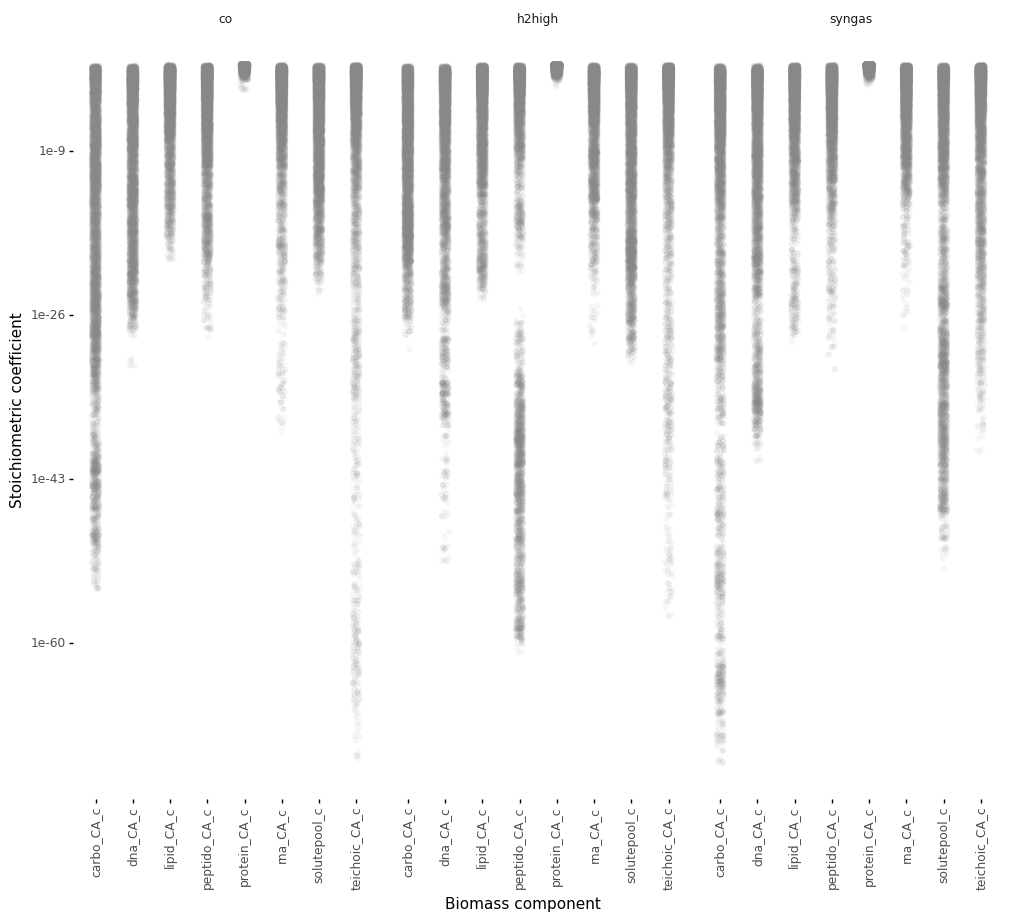

<ggplot: (8369727081114)>

In [67]:
(
    ggplot(df_mu_c, aes(x="metabolite", y="coefficient"))
    + geom_jitter(alpha=0.05, height=0, width=0.1, color="gray")
    + facet_wrap("~condition")
    #+ geom_point(data=df_move, mapping=aes(shape="var"), size=2, color="black")
    + theme_tufte()
    + scale_y_log10()
    + xlab("Biomass component")
    + ylab("Stoichiometric coefficient")
    + theme(
        figure_size=(12, 10), legend_position=(0.78, 0.8), axis_text_x=element_text(angle=90))
)

Is the parent distribution $\mu$ _looking_ good?

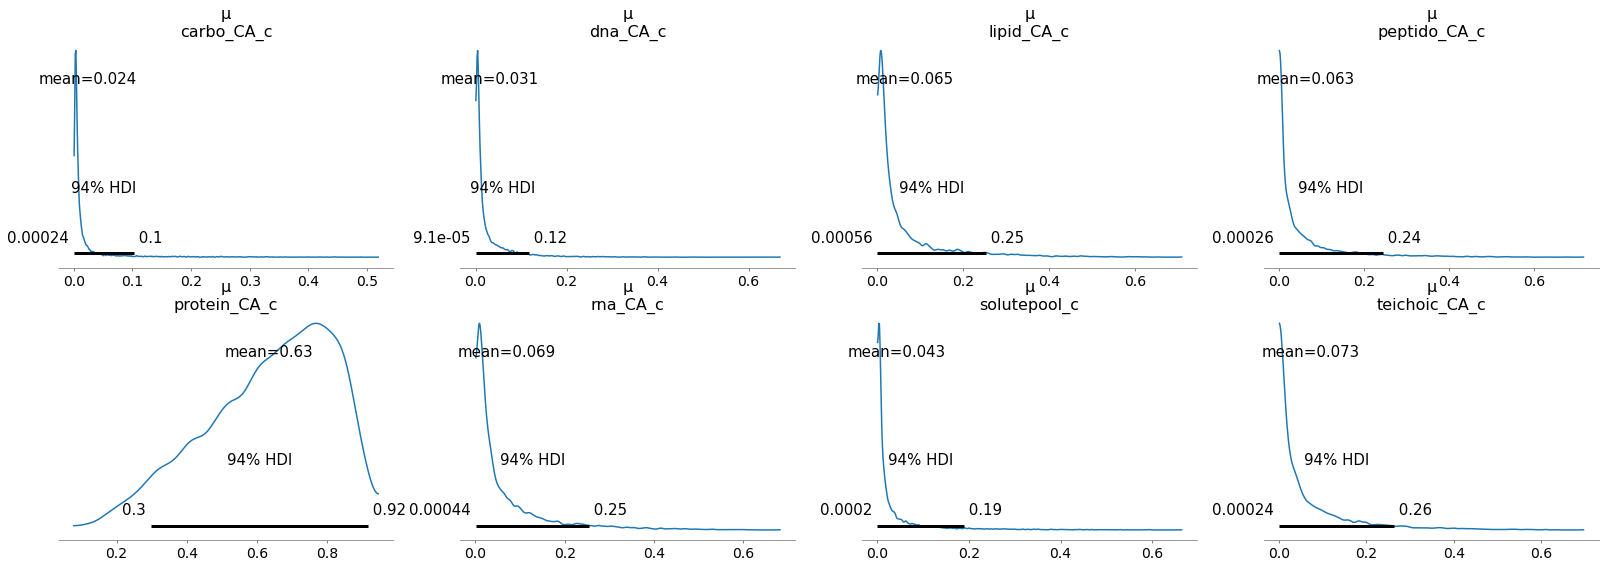

In [13]:
_ = az.plot_posterior(idata, var_names=["μ"])

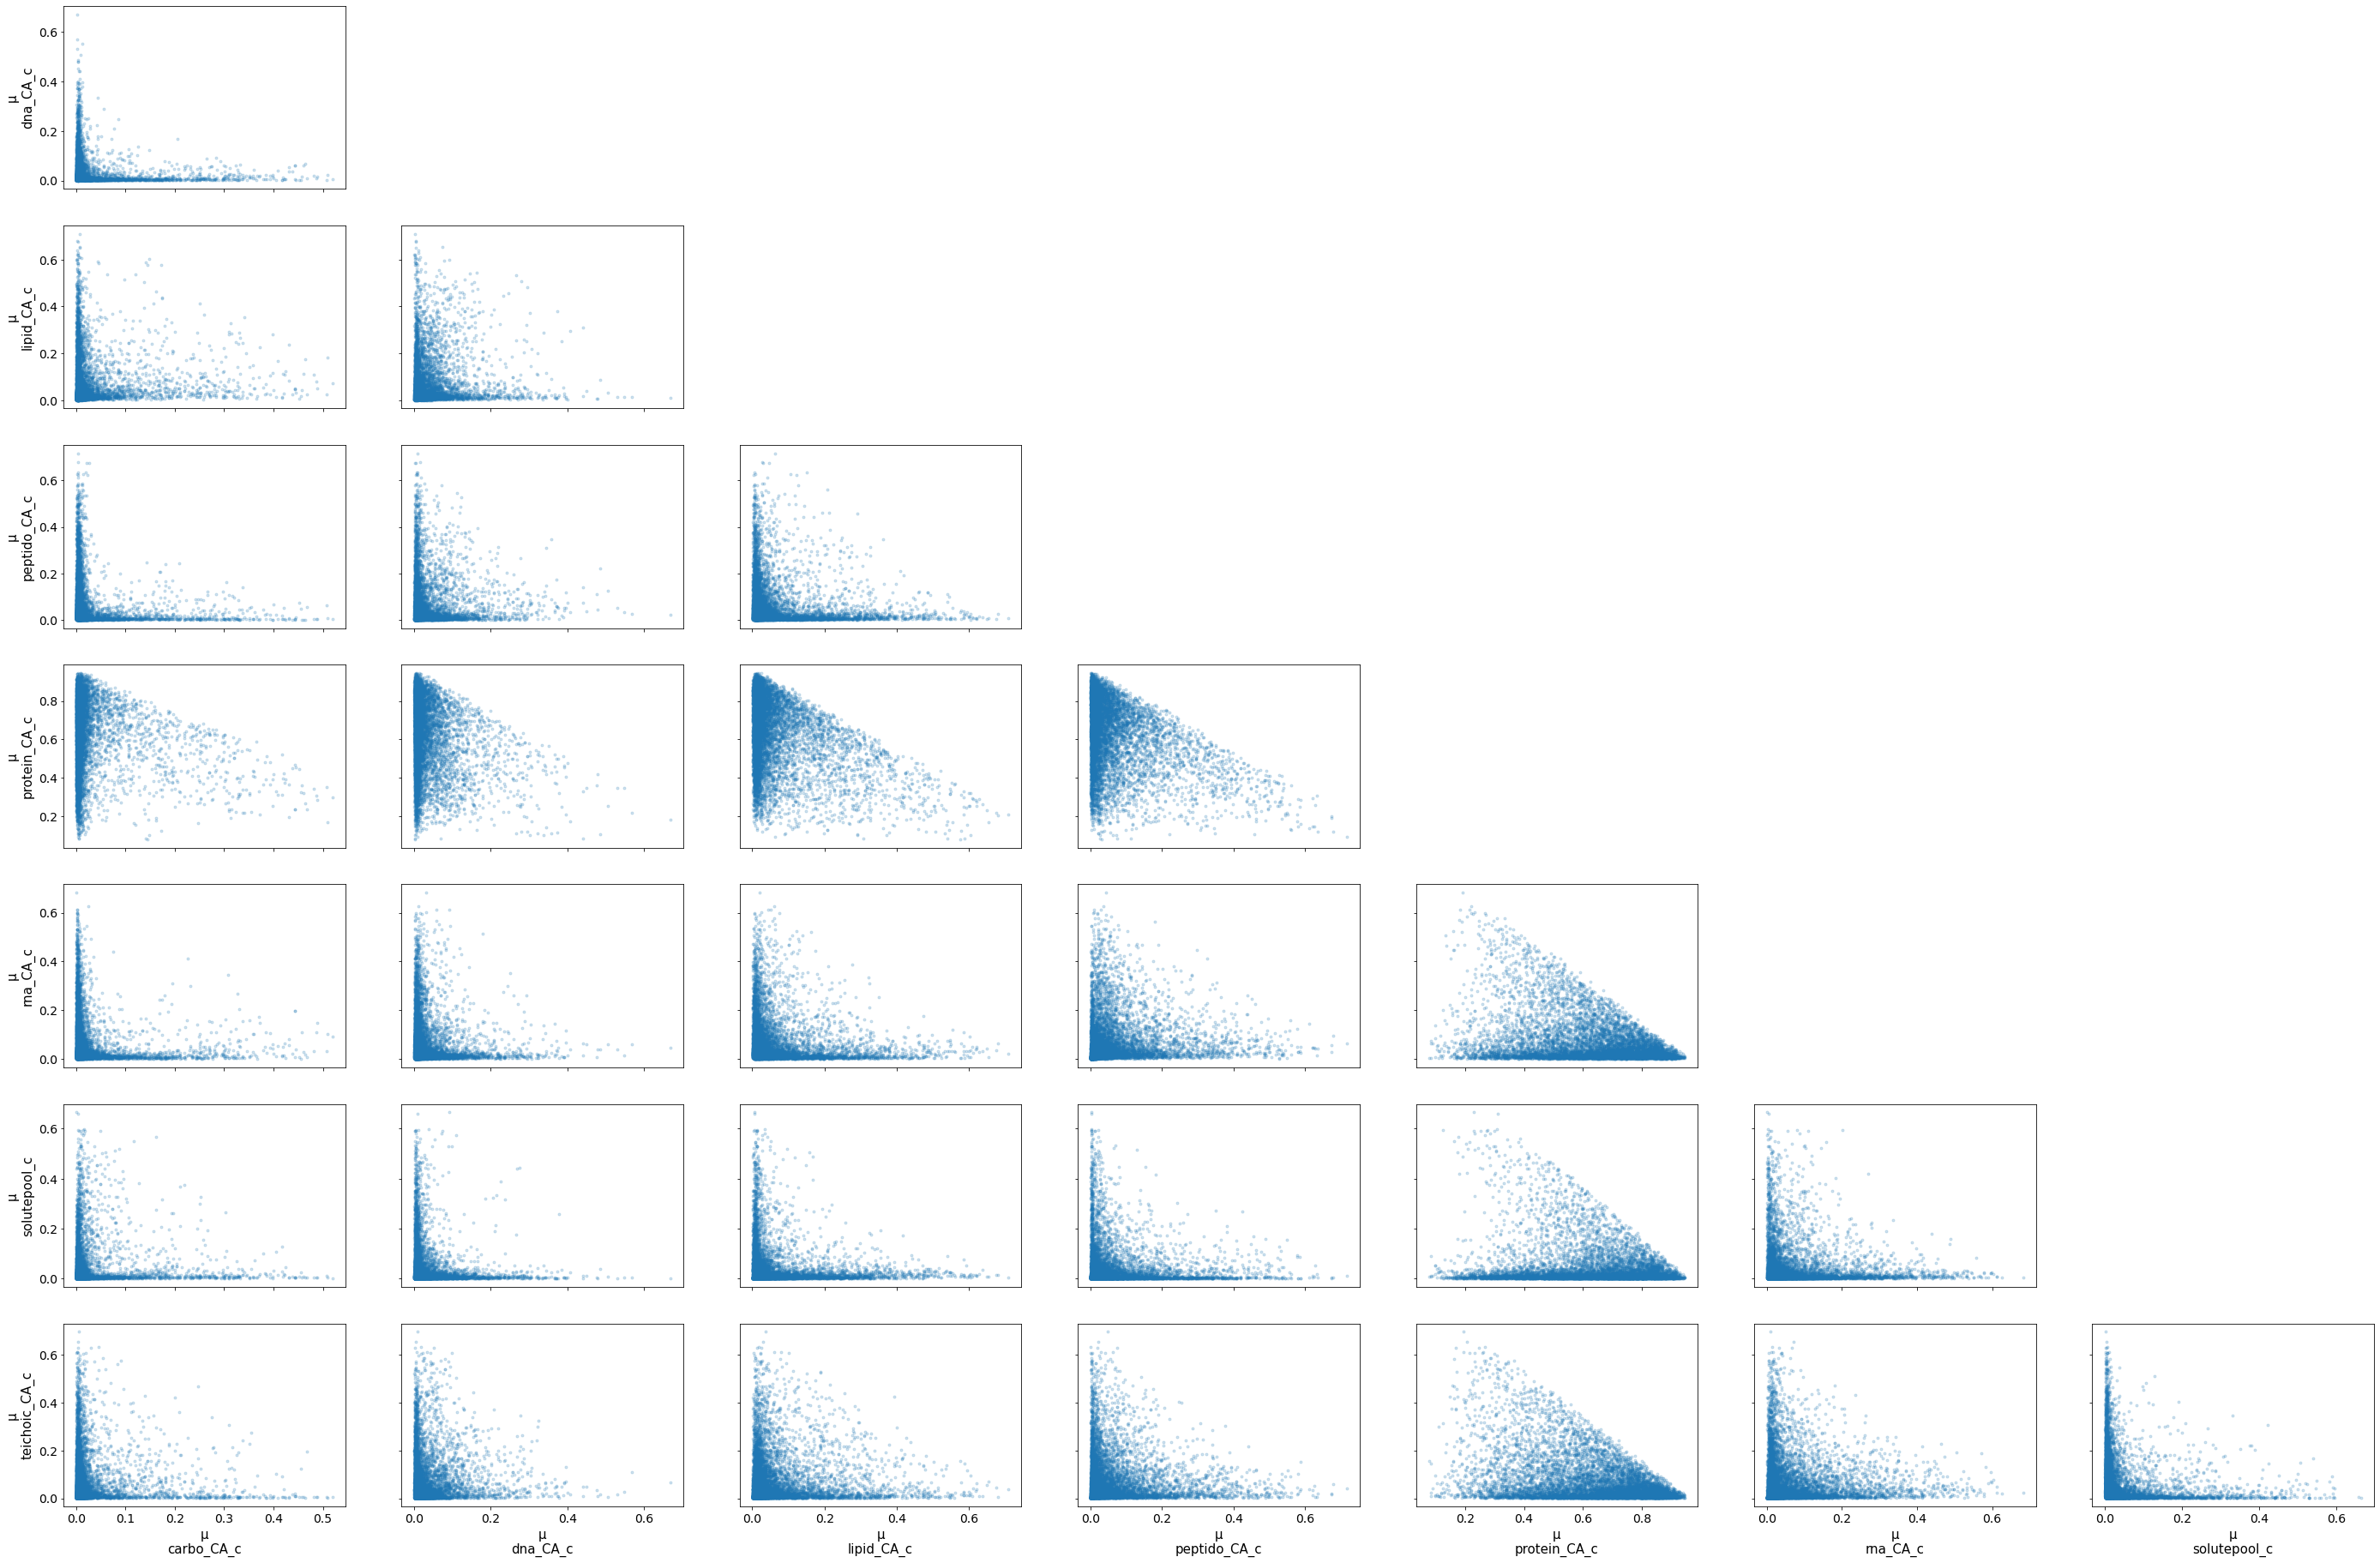

In [14]:
ax = az.plot_pair(
    idata,
    var_names="μ",
    scatter_kwargs={"alpha": 0.2},
)

How well does the model predict the different conditions?

Let's first look at the current behaviour of the model with the old biomass composition.

In [15]:
df_prev = []
for cond in df.condition.unique():
    df_cond = df.loc[
        (df.condition == cond) & (df["var"] == "input"), ["value", "reaction"]
    ]
    print(cond)
    for _, (value, reaction) in df_cond.iterrows():
        model.reactions.get_by_id(reaction).bounds = value, value
    res = model.optimize()[df.loc[df["var"] == "pred", "reaction"].unique()]
    print(res, end="\n\n")
    res = res.to_frame()
    res["condition"] = cond
    df_prev.append(res)
df_prev = pd.concat(df_prev)

syngas
cpd00029_ext_b    2.792998
cpd00363_ext_b    3.214100
cpd01947_ext_b    0.000000
Name: fluxes, dtype: float64

co
cpd00029_ext_b    0.376944
cpd00363_ext_b    3.443239
cpd01947_ext_b    0.000000
Name: fluxes, dtype: float64

h2high
cpd00029_ext_b    0.000000
cpd00363_ext_b    7.023662
cpd01947_ext_b    0.000000
Name: fluxes, dtype: float64



In [16]:
df_prev["exchange"] = df_prev.index
df_prev["var"] = "old biomass"
df_prev = df_prev.reset_index(drop=True)

In [17]:
def test_posterior_likelihood(data, model, df, n=100):
    """Take n samples from μ_softmax and evaluate the likelihood."""
    μ_softmax = data.posterior.μ_softmax
    conditions = data.posterior.μ_softmax.condition.to_numpy()
    chain_idx = np.random.randint(0, μ_softmax.shape[0] - 1, n)
    draw_idx = np.random.randint(0, μ_softmax.shape[1] - 1, n)
    results = []
    for chain, draw in tqdm(zip(chain_idx, draw_idx), total=n):
        for cond in conditions:
            model.reactions.bio2_c0.add_metabolites(
                {
                    met: -coef
                    for met, coef in zip(
                        model.reactions.bio2_c0.reactants,
                        data.posterior["μ_softmax"].sel(
                            metabolite=[
                                met.id[2:] for met in model.reactions.bio2_c0.reactants
                            ],
                            chain=chain,
                            draw=draw,
                            condition=cond,
                        ),
                    )
                },
                False,
            )
            df_cond = df.loc[
                (df.condition == cond) & (df["var"] == "input"), ["value", "reaction"]
            ]
            for _, (value, reaction) in df_cond.iterrows():
                model.reactions.get_by_id(reaction).bounds = value, value
            result = model.optimize()[
                df.loc[df["var"] == "pred", "reaction"].unique()
            ].to_frame()
            result["condition"] = cond
            result["draw"] = chain * draw
            results.append(result)
    return pd.concat(results)

In [18]:
posterior_fluxes = test_posterior_likelihood(idata, model, df, n=500)

100%|██████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.75it/s]


In [19]:
posterior_fluxes["exchange"] = posterior_fluxes.index

In [20]:
from plotnine import *

In [21]:
df_move = df.copy()

In [22]:
df_move = df_move.rename({"value": "fluxes", "reaction": "exchange"}, axis=1)
df_move = df_move[df_move["var"] == "pred"]
df_move["var"] = "true"

In [23]:
df_move = pd.concat([df_move, df_prev])

In [24]:
df_move.exchange = df_move.exchange.replace(
    {
        "cpd00029_ext_b": "acetate",
        "cpd00363_ext_b": "ethanol",
        "cpd01947_ext_b": "2,3-BDO",
    }
)
posterior_fluxes.exchange = posterior_fluxes.exchange.replace(
    {
        "cpd00029_ext_b": "acetate",
        "cpd00363_ext_b": "ethanol",
        "cpd01947_ext_b": "2,3-BDO",
    }
)

In [25]:
comp_exchange_plot = (
    ggplot(posterior_fluxes, aes(x="exchange", y="fluxes"))
    + geom_jitter(alpha=0.2, color="gray")
    + geom_violin(alpha=0.2, color="gray")
    + facet_wrap("~condition")
    + geom_point(data=df_move, mapping=aes(shape="var"), size=2, color="black")
    + theme_tufte()
    + theme(
        figure_size=(12, 10), legend_position=(0.78, 0.8)
    )  # , axis_text_x=element_text(angle=90))
)

### Figure: posterior byproduct formation

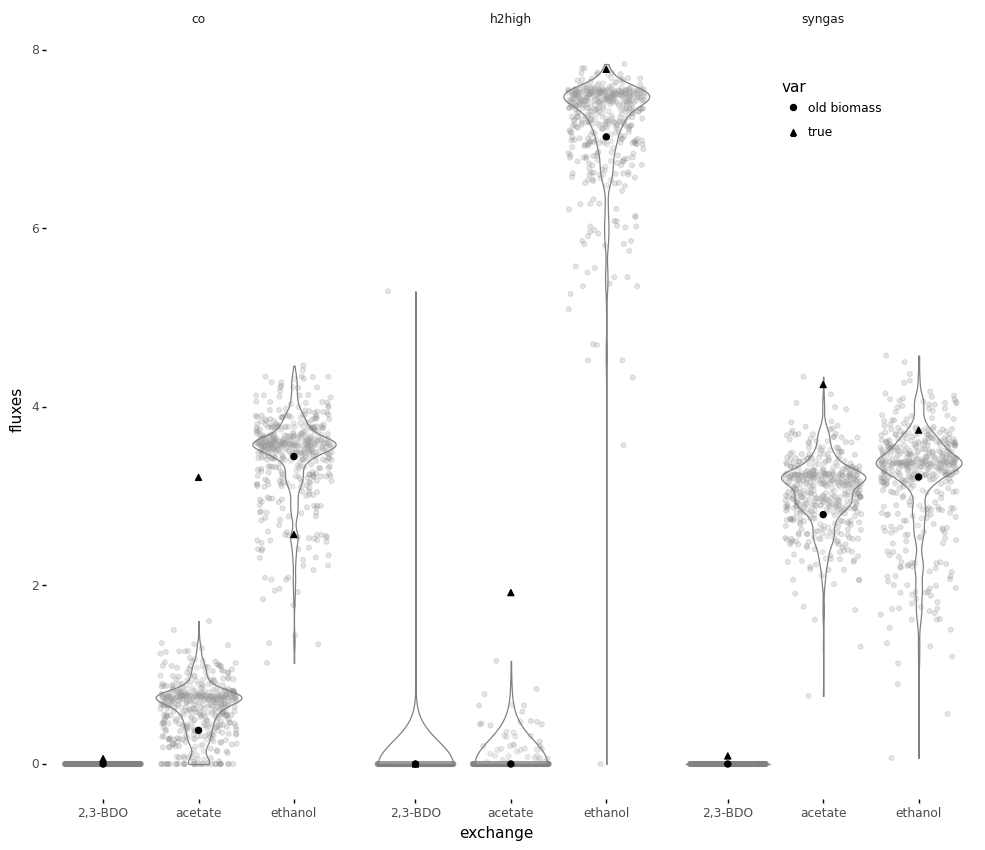

<ggplot: (8743640928627)>

In [26]:
comp_exchange_plot

In [27]:
comp_exchange_plot.save(
    "/home/georg/OneDrive/labook/graphics/comp_exchange_diri.pdf", dpi=300
)

/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12 x 10 in image.
/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/georg/OneDrive/labook/graphics/comp_exchange_diri.pdf


There seems to be a structural boundary between the acetate/ethanol ration that hampers the accurate prediction of those.

Let's check the actual values and how they are correlated.

In [28]:
ac_etoh = posterior_fluxes[posterior_fluxes.exchange.isin(["acetate", "ethanol"])]

In [29]:
import matplotlib.pyplot as plt

In [30]:
true_move_wide = (
    df_move[
        (df_move["var"] == "true") & (df_move["exchange"].isin(["acetate", "ethanol"]))
    ]
    .loc[:, ~(df.columns == "var")]
    .set_index(["exchange", "condition"])
    .unstack()
)
old_move_wide = (
    df_move[
        (df_move["var"] != "true") & (df_move["exchange"].isin(["acetate", "ethanol"]))
    ]
    .loc[:, ~(df.columns == "var")]
    .set_index(["exchange", "condition"])
    .unstack()
)
old_move_wide = old_move_wide.reset_index()
true_move_wide = true_move_wide.reset_index()
true_move_wide = true_move_wide.reset_index(drop=True).set_index("exchange")
old_move_wide = old_move_wide.reset_index(drop=True).set_index("exchange")
true_move_wide.columns = true_move_wide.columns.droplevel(0)
old_move_wide.columns = old_move_wide.columns.droplevel(0)

### Figure: Rate of acetate/ethanol

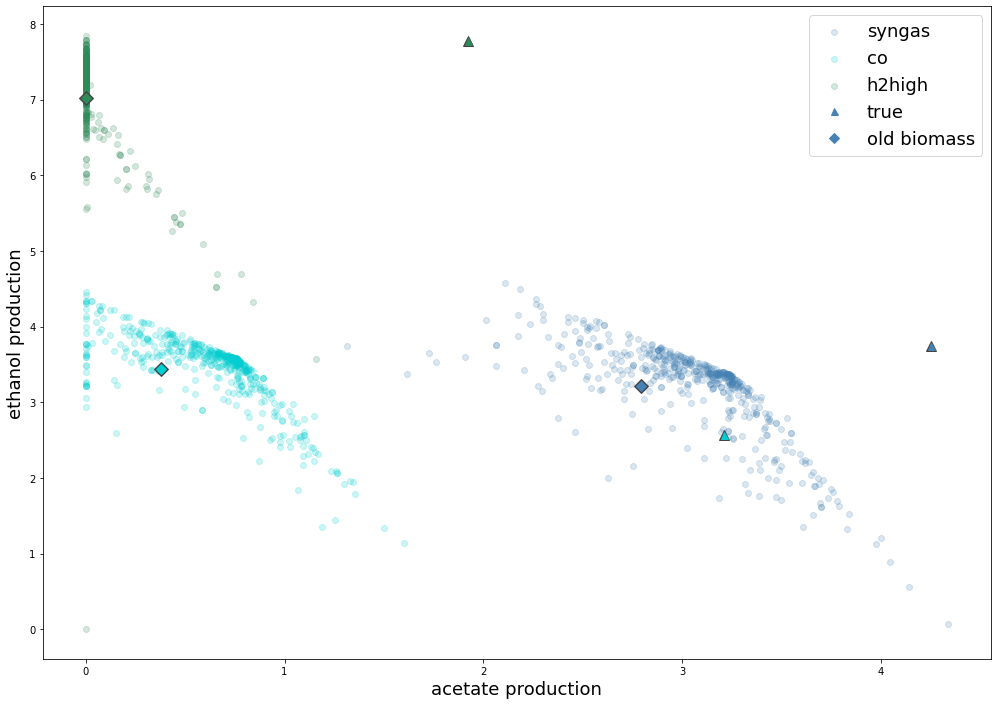

In [31]:
plt.figure(figsize=(17, 12))
plt.scatter(
    ac_etoh.loc[
        (ac_etoh.exchange == "acetate") & (ac_etoh.condition == "syngas"), "fluxes"
    ],
    ac_etoh.loc[
        (ac_etoh.exchange == "ethanol") & (ac_etoh.condition == "syngas"), "fluxes"
    ],
    color="steelblue",
    label="syngas",
    alpha=0.2,
)
plt.scatter(
    ac_etoh.loc[
        (ac_etoh.exchange == "acetate") & (ac_etoh.condition == "co"), "fluxes"
    ],
    ac_etoh.loc[
        (ac_etoh.exchange == "ethanol") & (ac_etoh.condition == "co"), "fluxes"
    ],
    color="darkturquoise",
    label="co",
    alpha=0.2,
)
plt.scatter(
    ac_etoh.loc[
        (ac_etoh.exchange == "acetate") & (ac_etoh.condition == "h2high"), "fluxes"
    ],
    ac_etoh.loc[
        (ac_etoh.exchange == "ethanol") & (ac_etoh.condition == "h2high"), "fluxes"
    ],
    color="seagreen",
    label="h2high",
    alpha=0.2,
)

plt.plot(
    true_move_wide.loc["acetate", "syngas"],
    true_move_wide.loc["ethanol", "syngas"],
    "^",
    color="#454345",
    markersize=10,
)
plt.plot(
    true_move_wide.loc["acetate", "co"],
    true_move_wide.loc["ethanol", "co"],
    "^",
    color="#454345",
    markersize=10,
)
plt.plot(
    true_move_wide.loc["acetate", "h2high"],
    true_move_wide.loc["ethanol", "h2high"],
    "^",
    color="#454345",
    markersize=10,
)
plt.plot(
    old_move_wide.loc["acetate", "syngas"],
    old_move_wide.loc["ethanol", "syngas"],
    "D",
    color="#454345",
    markersize=10,
)
plt.plot(
    old_move_wide.loc["acetate", "co"],
    old_move_wide.loc["ethanol", "co"],
    "D",
    color="#454345",
    markersize=10,
)
plt.plot(
    old_move_wide.loc["acetate", "h2high"],
    old_move_wide.loc["ethanol", "h2high"],
    "D",
    color="#454345",
    markersize=10,
)
plt.plot(
    true_move_wide.loc["acetate", "syngas"],
    true_move_wide.loc["ethanol", "syngas"],
    "^",
    color="steelblue",
    label="true",
    markersize=7,
)
plt.plot(
    true_move_wide.loc["acetate", "co"],
    true_move_wide.loc["ethanol", "co"],
    "^",
    color="darkturquoise",
    markersize=7,
)
plt.plot(
    true_move_wide.loc["acetate", "h2high"],
    true_move_wide.loc["ethanol", "h2high"],
    "^",
    color="seagreen",
    markersize=7,
)
plt.plot(
    old_move_wide.loc["acetate", "syngas"],
    old_move_wide.loc["ethanol", "syngas"],
    "D",
    color="steelblue",
    label="old biomass",
    markersize=7,
)
plt.plot(
    old_move_wide.loc["acetate", "co"],
    old_move_wide.loc["ethanol", "co"],
    "D",
    color="darkturquoise",
    markersize=7,
)
plt.plot(
    old_move_wide.loc["acetate", "h2high"],
    old_move_wide.loc["ethanol", "h2high"],
    "D",
    color="seagreen",
    markersize=7,
)

plt.ylabel("ethanol production", fontsize=18)
plt.xlabel("acetate production", fontsize=18)
plt.legend(fontsize=18)
plt.savefig(
    "/home/georg/OneDrive/labook/graphics/ethanol_acetate_diriclose.pdf", dpi=300
)

In [32]:
true_move_wide.iloc[0, :].to_list()[1:]

[1.92, 4.25]

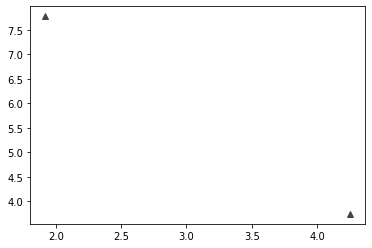

In [33]:
plt.plot(
    true_move_wide.iloc[0, :].to_list()[1:],
    true_move_wide.iloc[1, :].to_list()[1:],
    "^",
    color="#454345",
    label="true",
)

<AxesSubplot:>

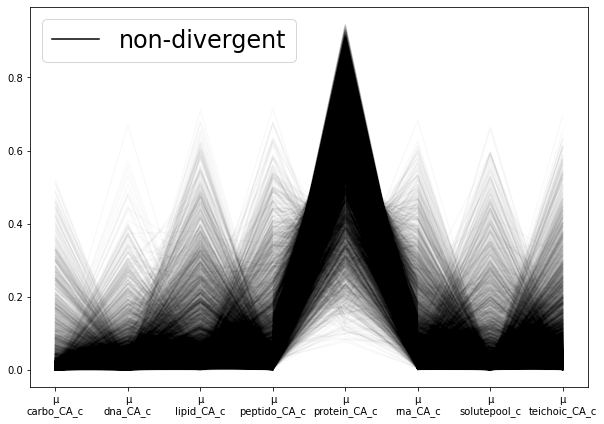

In [34]:
az.plot_parallel(idata, var_names="μ", figsize=(10, 7))

<AxesSubplot:>

/home/georg/.virtualenvs/cobra/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


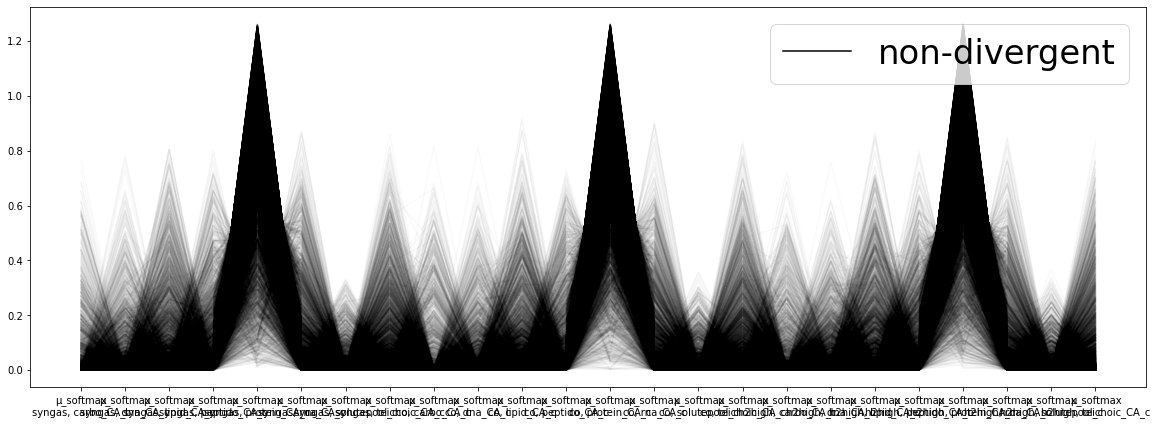

In [35]:
az.plot_parallel(idata, var_names="μ_softmax", figsize=(20, 7))

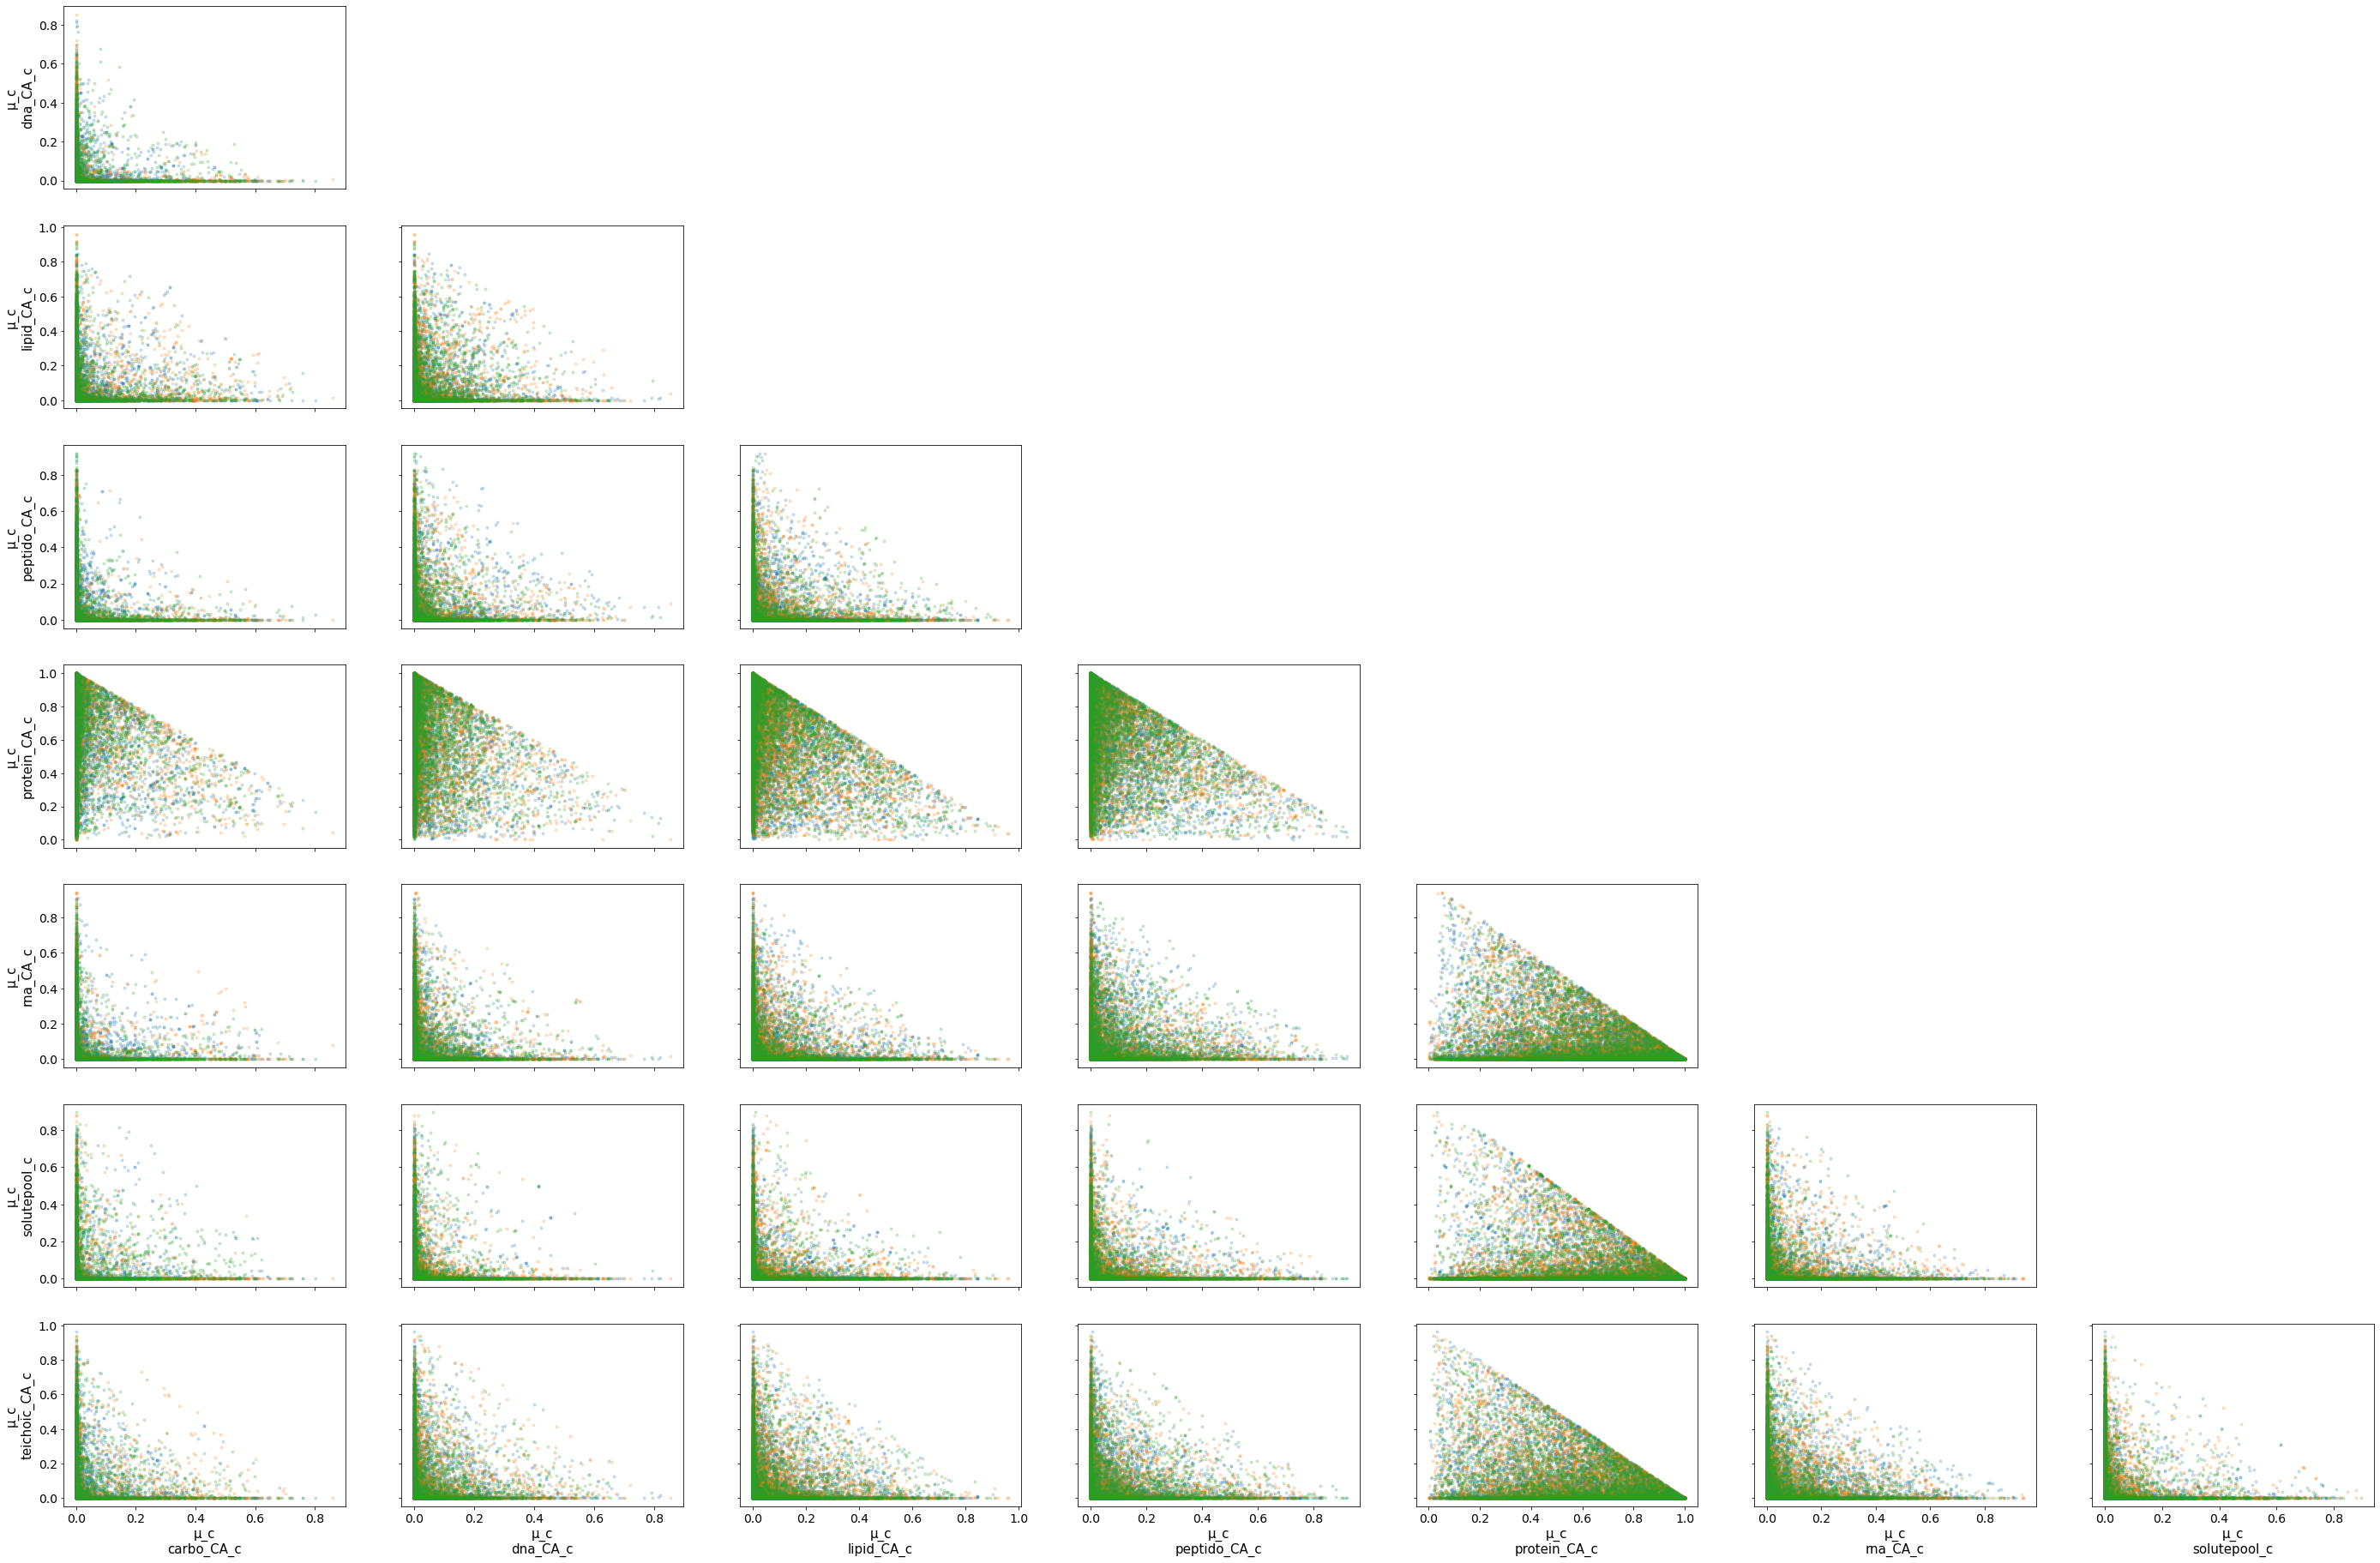

In [36]:
ax = az.plot_pair(
    idata,
    var_names="μ_c",
    coords={"condition": "syngas"},
    show=False,
    scatter_kwargs={"alpha": 0.2},
)
ax = az.plot_pair(
    idata,
    var_names="μ_c",
    coords={"condition": "co"},
    ax=ax,
    show=False,
    scatter_kwargs={"alpha": 0.2},
)
_ = az.plot_pair(
    idata,
    var_names="μ_c",
    coords={"condition": "h2high"},
    ax=ax,
    scatter_kwargs={"alpha": 0.2},
)

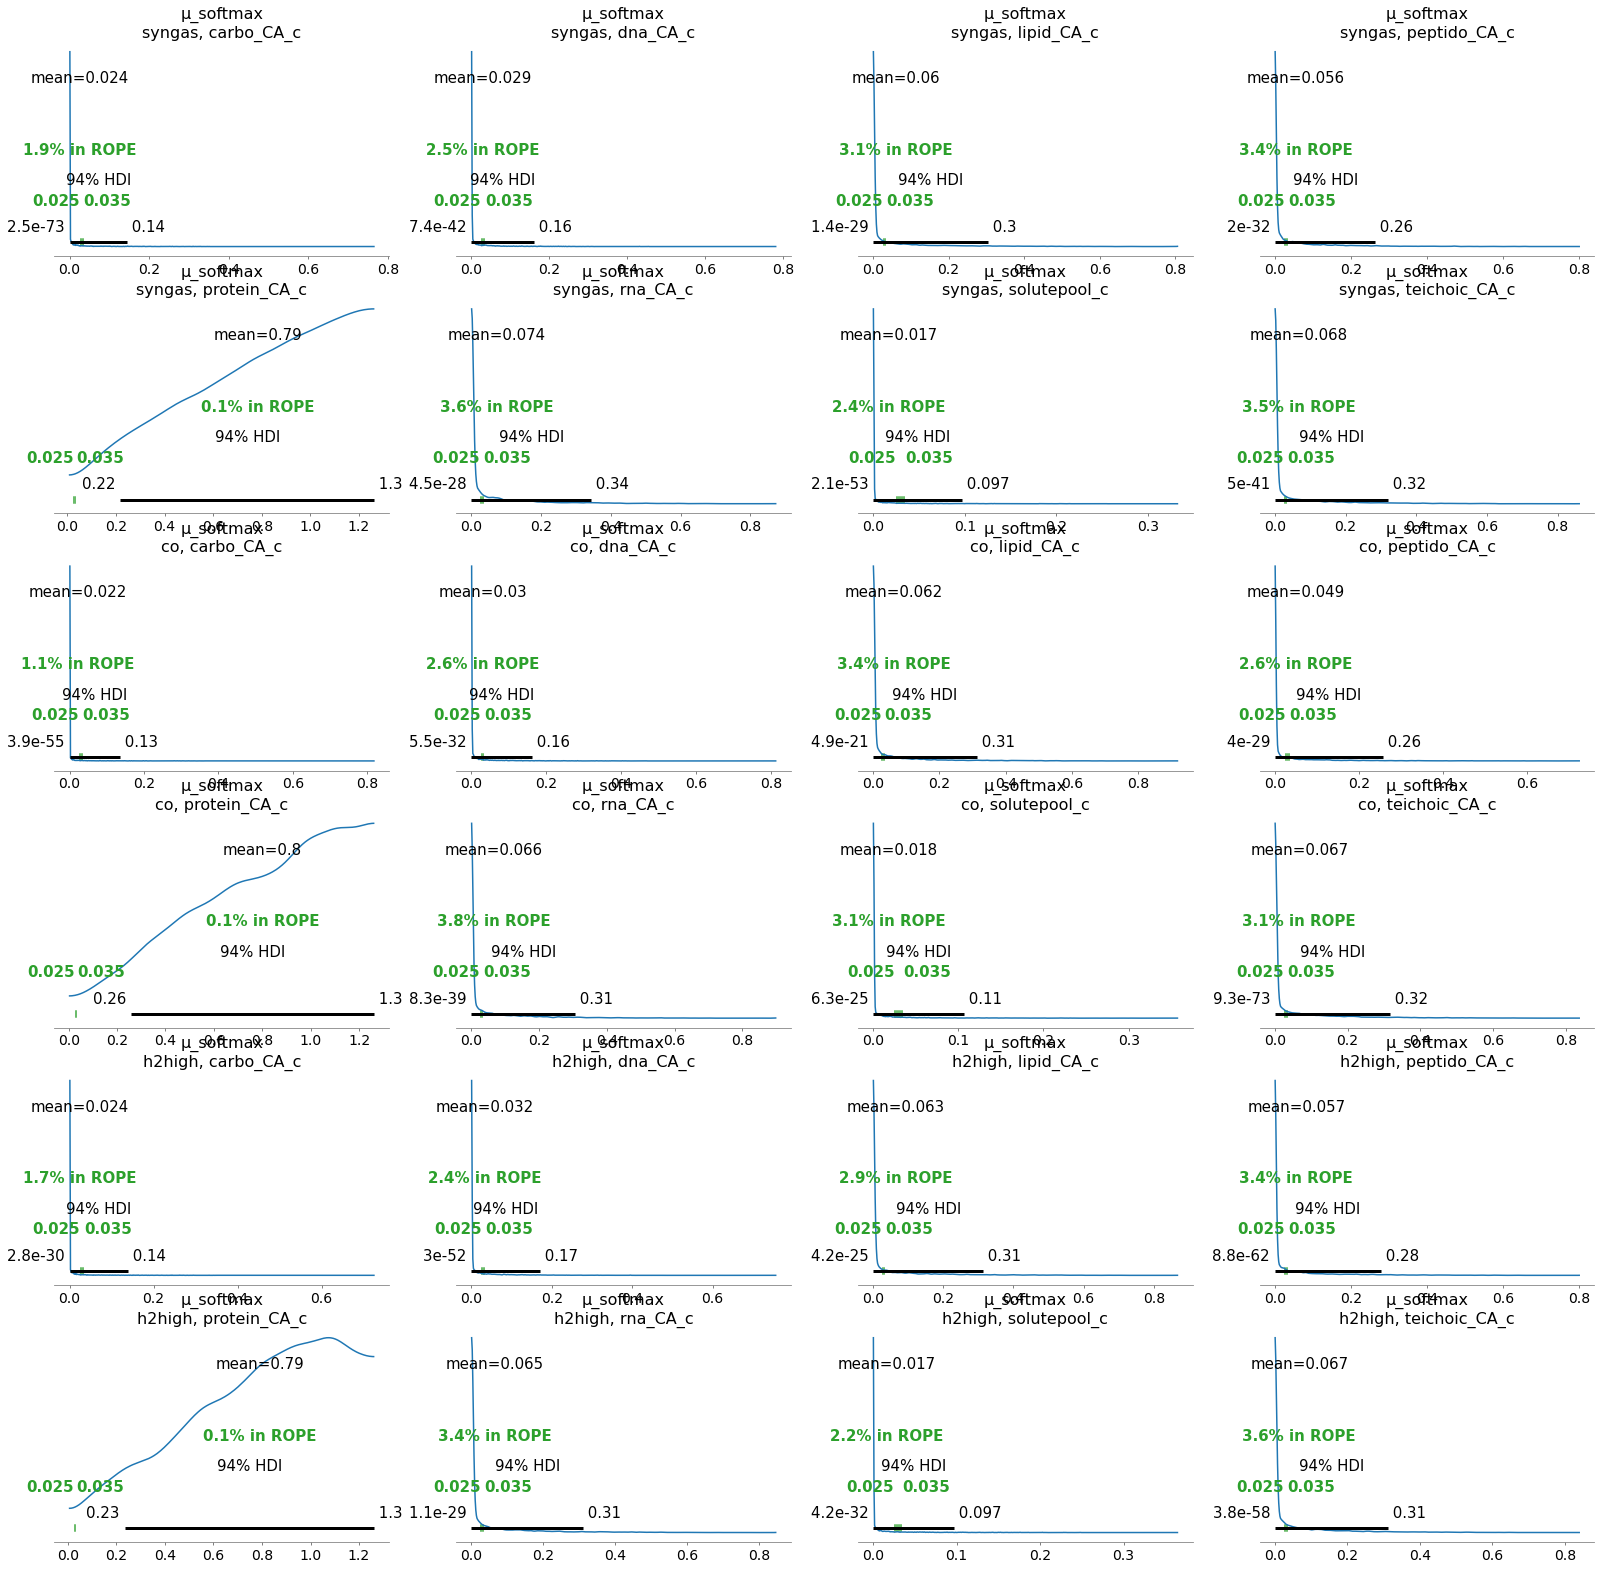

In [37]:
_ = az.plot_posterior(
    idata, var_names="μ_softmax", rope=(0.025, 0.035)
)  # just some random ROPE